# Trigger files
This notebook is intended to create the descriptive, streams information and timestamps as '.csv' files, and trigger files.
- Descriptive files contain information about the recordings such as duration, sampling rate, names of streams collected, type, etc.
- Stream information files contain all data gathered during recording with respective timestamps (e.g., head and eye tracking, object names)
- The trigger files contain information about the time when an image was shown, the type of image, distance, rotation and block. These files are required to set the stimulus onset during the eeg data analysis.

In [1]:
import copy
import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import pyxdf
import dataframe_image as dfi
import seaborn as sns
from scipy.signal import find_peaks
from operator import itemgetter
from tqdm.notebook import tqdm


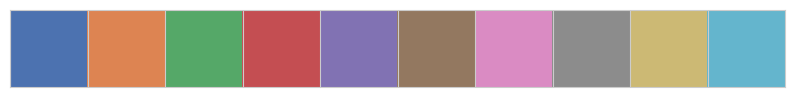

In [2]:
# choosing the color palette
deep_pal = sns.color_palette('deep')
sns.palplot(deep_pal)
sns.set_style("white")

In [306]:
# path to data stored
r_path = "data"
# path to store trigger data
t_path = r_path + '/triggers'
# path to store eye-tracking data
e_path = r_path + '/eye_tracking'

# Get some quick idea about the files
files = os.listdir(r_path)  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}
file_names = []
for i, file in enumerate(files):  # store and display all files
    if file.endswith('.xdf') and 'room1' in file:
        file_names.append(file)
        created = os.path.getmtime(f"data/{file}")  # creation timestamp
        created = datetime.datetime.fromtimestamp(created)  # translate as datetime
        created = created.strftime("%d.%m.%Y %H:%M")  # arrange it
        recordings[i] = {"file": file, "created": created}
        #check for a second recording for same subject
        if os.path.isfile(f"data/{file.replace('room1', 'room2')}"):
            print(f"2nd room exists for {file}")

# print(file_names)
files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

Included:


{1: {'file': '42_room1_081122.xdf', 'created': '08.11.2022 15:14'}}

## 1. Load data

In [307]:
# check streams for recording 0
file_to_use = file_names[0]
print(file_to_use)
streams, _ = pyxdf.load_xdf(f"data/{file_to_use}")

42_room1_081122.xdf


In [308]:
# stream channel names in recording 0
s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
s_channels
# Get an idea of stream 'ImageInfo'
# streams[7]
# streams[7]['info']
# streams[7]['time_series']
# streams[7]['time_stamps']
# length of time_stamps
# len(streams[2]['time_stamps'])
# print all source_ids in stream 7
# source_ids = [i['info']['source_id'] for i in streams]
# source_ids

{'ImagesOrder': 0,
 'EyeTrackingLocal': 1,
 'EyeTrackingWorld': 2,
 'HitObjectNames': 3,
 'HitObjectPositions': 4,
 'ImageInfo': 5,
 'HeadTracking': 6,
 'HitPositionOnObjects': 7,
 'openvibeSignal': 8,
 'Visual': 9,
 'ValidationError': 10}

In [330]:
streams

[{'info': defaultdict(list,
              {'name': ['ImagesOrder'],
               'type': ['Markers'],
               'channel_count': ['2'],
               'channel_format': ['string'],
               'source_id': ['188f0e9e-93e4-40cf-b130-cb209aa58af2'],
               'nominal_srate': ['0.000000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['508148.5166149000'],
               'uid': ['7b8acb79-7462-40f9-a60a-5481c875bc9b'],
               'session_id': ['default'],
               'hostname': ['ml03'],
               'v4address': [None],
               'v4data_port': ['16581'],
               'v4service_port': ['16581'],
               'v6address': [None],
               'v6data_port': ['16581'],
               'v6service_port': ['16581'],
               'desc': [defaultdict(list,
                            {'arrayOfImages': [None],
                             'orderOfImageIndexesToDisplay': [None]})],
               'stream_id': 5,
  

In [329]:
# streams[3]['time_stamps'][0:550] - streams[3]['time_stamps'][0]
print(streams[8]['time_stamps'][0] -streams[5]['time_stamps'][0])
print(streams[10]['time_stamps'][0] - streams[8]['time_stamps'][0])
print(streams[5]['time_stamps'][0])

-20.7321958487737
38.25522214459488
352826.52693857567


In [310]:
def stract_eeg_data(streams, time_ref_stream='openvibeSignal'):
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    eeg = s_channels[time_ref_stream]
    # choose 6144 samples which correspond to 6 sec of recording
    df_eeg = pd.DataFrame(streams[eeg]['time_series'][0:6144,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
    df_eeg['timestamps'] = streams[eeg]['time_stamps'][0] - streams[eeg]['time_stamps'][0]
    # have all timestamps
    df_eeg_all = pd.DataFrame(streams[eeg]['time_series'][:,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
    df_eeg_all['timestamps'] = streams[eeg]['time_stamps']
    return df_eeg, df_eeg_all

In [311]:
df_eeg, df_eeg_all = stract_eeg_data(streams)
df_eeg_all

,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,timestamps
0,-12428.330078,-7218.074707,-10818.745117,-3367.190674,-3588.256836,-3512.324463,3458.368164,-2935.853027,-2055.376709,-9323.012695,352805.794743
1,-12434.416992,-7216.088867,-10808.575195,-3363.788330,-3587.723389,-3513.391113,3454.671875,-2939.365723,-2054.089355,-9324.060547,352805.795719
2,-12434.748047,-7220.410645,-10805.945312,-3363.917236,-3586.528076,-3515.211670,3451.140869,-2937.489746,-2062.456787,-9324.116211,352805.796696
3,-12431.750000,-7225.228516,-10818.708008,-3363.199951,-3582.721436,-3514.163574,3451.343262,-2940.340332,-2061.095947,-9322.975586,352805.797672
4,-12425.258789,-7224.566406,-10840.922852,-3361.710449,-3582.942139,-3512.710693,3446.083740,-2940.671387,-2061.923584,-9322.479492,352805.798649
...,...,...,...,...,...,...,...,...,...,...,...
4269979,-19439.093750,-19177.937500,-15138.463867,-12443.758789,-10794.672852,-16039.555664,26673.351562,-12575.652344,-9128.079102,-32426.589844,356975.696111
4269980,-19444.132812,-19180.347656,-15137.765625,-12445.634766,-10795.168945,-16039.684570,26668.312500,-12574.457031,-9129.807617,-32427.013672,356975.697087
4269981,-19442.386719,-19181.339844,-15145.250000,-12445.910156,-10794.911133,-16042.221680,26666.070312,-12574.511719,-9132.565430,-32428.650391,356975.698064
4269982,-19443.378906,-19182.480469,-15155.033203,-12448.062500,-10796.768555,-16041.873047,26668.607422,-12575.615234,-9134.846680,-32429.974609,356975.699040


In [312]:
# visualize eeg data only
def visualize_eeg(df):
    fig, ax = plt.subplots(nrows=10, figsize=(15, 6), sharex=True)
    plt.rcParams.update({'font.size': 10})
    for i, value in enumerate(df.columns[0:10]):
        sns.lineplot(x= df['timestamps'], y = df[value], ax=ax[i], linewidth=0.5)
        ax[i].set(yticklabels=[])
        ax[i].set_xlim(0,None)
        ax[i].set_xlabel('Time (s)', fontsize=12)
        sns.despine(top=True, bottom=True)
    plt.show()
# plt.savefig("data/images/" + "eeg_6seconds" + ".pdf", format='pdf', dpi=1200)


In [313]:
# visualize_eeg(df_eeg)

In [315]:
def get_stream_timestamps(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal'):
    times_egg_start_ts = streams[s_channels[time_ref_stream]]['time_stamps'][0]
    times_egg_end_ts = streams[s_channels[time_ref_stream]]['time_stamps'][-1]

    times_unity_min = []
    times_unity_max = []
    for i, ch_name in enumerate(streams_keep):
        u = s_channels[ch_name]
        times_unity_min.append(streams[u]['time_stamps'][0])
        times_unity_max.append(streams[u]['time_stamps'][-1])

    times_unity_start_ts = np.min(times_unity_min)
    times_unity_end_ts = np.max(times_unity_max)

    start_diff = times_unity_start_ts - times_egg_start_ts # start difference between unity and eeg
    end_diff = times_unity_end_ts - times_egg_end_ts # end difference between unity and eeg
    dynamic_shift = end_diff - start_diff # drift increase over time

    print(f"Participant UID: {uid}")
    print(f"{time_ref_stream} start time is {times_egg_start_ts} and end time is {times_egg_end_ts}")
    print(f"Unity start time is {times_unity_start_ts} and end time is {times_unity_end_ts}")
    i = 0
    for _, ch_name in enumerate(streams_keep):
        print(f" -- Unity {ch_name} start time is {times_unity_min[i]} and end time is {times_unity_max[i]}")
        i += 1
    print(f" -- All Unity streams start time difference is {round(1000 * (np.max(times_unity_min) - np.min(times_unity_min)), 1)} (milliseconds)")
    print(f" -- All Unity streams end time difference is {round(1000 * (np.max(times_unity_max) - np.min(times_unity_max)), 1)} (milliseconds)")
    print(f"Starting drift between Unity and {time_ref_stream} is {1000*start_diff} (milliseconds)")
    print(f"Ending drift between Unity and {time_ref_stream} is {1000*end_diff} (milliseconds)")
    print(f"Additional drift over time is {1000*dynamic_shift} (milliseconds)")

    return times_egg_start_ts, times_egg_end_ts, times_unity_start_ts, times_unity_end_ts, start_diff, end_diff, dynamic_shift

In [318]:
get_stream_timestamps(streams, streams_keep=['ValidationError'])

Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
openvibeSignal start time is 352805.7947427269 and end time is 356975.70001679234
Unity start time is 352844.0499648715 and end time is 356604.82449761167
 -- Unity ValidationError start time is 352844.0499648715 and end time is 356604.82449761167
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 38255.22214459488 (milliseconds)
Ending drift between Unity and openvibeSignal is -370875.5191806704 (milliseconds)
Additional drift over time is -409130.74132526526 (milliseconds)


(352805.7947427269,
 356975.70001679234,
 352844.0499648715,
 356604.82449761167,
 38.25522214459488,
 -370.8755191806704,
 -409.13074132526526)

In [319]:
352844.0499648715 - 352805.7947427269
# 356975.70001679234
# /

38.25522214459488

In [303]:
def get_continuous_time_periods(time_stamps_input):
    # duration = (time_stamps_input[-1] - time_stamps_input[0])/60
    # print(f'Recording duration: {duration} minutes')
    time_stamps_shift = time_stamps_input[1:-1] - time_stamps_input[0:-2]
    time_stamps_shift_pd = pd.array(time_stamps_shift)
    cutoff = np.mean(time_stamps_shift) + 2*np.std(time_stamps_shift)
    #cutoff = 30
    last = 0
    chunks = []
    for i, val in enumerate(time_stamps_shift):
        if val > cutoff:
            chunks.append([time_stamps_input[last:i]])
            last = i+1
    chunks.append([time_stamps_input[last:-1]])
    return chunks

def calcualte_fps(time_stamp_chunk):
    frame_count = np.size(time_stamp_chunk)
    chunck_duration = (np.max(time_stamp_chunk) - np.min(time_stamp_chunk) )/ 60
    # if chunck_duration > 1:
    fps = frame_count / (chunck_duration * 60)
    return fps

for chunk in get_continuous_time_periods(streams[s_channels['Visual']]['time_stamps']):
    print(calcualte_fps(chunk))
    print(np.size(chunk))
    print(chunk)

90.00108777713177
91964
[array([74451.19443608, 74451.20561416, 74451.21655033, ...,
       75472.98192192, 75472.9931123 , 75473.00430828])]
90.51291190312828
1585
[array([75517.70938111, 75517.71401144, 75517.71428034, ...,
       75535.19862771, 75535.20962799, 75535.22069487])]
90.00861684409323
89334
[array([75569.36738695, 75569.36763625, 75569.36779155, ...,
       76561.85013297, 76561.86127435, 76561.87236183])]
90.54688044909119
1585
[array([76594.77850175, 76594.78317268, 76594.78338099, ...,
       76612.26090801, 76612.27205549, 76612.28324617])]
90.00596329096156
124401
[array([76645.01941098, 76645.01965918, 76645.01980428, ...,
       78027.13898882, 78027.15011539, 78027.16116527])]
90.4903244470607
1585
[array([78073.69466624, 78073.70555742, 78073.70577882, ...,
       78091.18818318, 78091.19936406, 78091.21035104])]
90.01118781004921
70627
[array([78124.53066872, 78124.53095702, 78124.53113192, ...,
       78909.15541603, 78909.16643751, 78909.17757449])]


In [304]:
def describe_recordings(streams, file_name=''):
    ch_keys = ["name","type", "channel_count","channel_format","nominal_srate","desc","effective_srate","hostname", "created_at"]
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    # for i, ch_name in enumerate(s_channels):
    #     if ch_name in 'openvibeSignal':
    #         eeg_times = streams[i]['time_stamps']
    #         # calculate the recording duration based on first and last time_stamps
    #         duration = (eeg_times[-1]- eeg_times[0])/60
    #     if ch_name in 'Visual':
    #         # save  uid from visual stream
    #         uid = streams[i]['info']['uid'][0]
    #     if ch_name in 'ImageInfo':
    #         unity_times = streams[i]['time_stamps']
    #         # calculate the duration for the 1st unity half block
    #         block_1_duration  = (unity_times[30000] - unity_times[0])/60
    #         # Unity sampling rate (fps) for 1rst half block
    #         fps = 1 / (block_1_duration * 60 / 30000)
    # eeg_unity_timedelta_start = eeg_times[0] - unity_times[0]
    # eeg_unity_timedelta_end = eeg_times[-1] -unity_times[-1]
    # Get the streams timestamps
    times_egg_start_ts, times_egg_end_ts, times_unity_start_ts, times_unity_end_ts, start_diff, end_diff, dynamic_shift = get_stream_timestamps(streams)
    # Calculate the total duration of the recording
    duration = (times_egg_end_ts - times_egg_start_ts) / 60
    # Calculate the mean FPS for the Unity stream (it should be 90 fps)
    fps = np.mean([calcualte_fps(chunk) for chunk in get_continuous_time_periods(streams[s_channels['Visual']]['time_stamps'])])
    # print(fps)

    df = pd.DataFrame(columns=np.concatenate([['uid','file_name','duration (min)','unity_avg_fps','eeg_unity_ts_delta_start(ms)','eeg_unity_ts_delta_end(ms)','ts_drift_end(ms)','stream_id'], ch_keys]))
    id_o = []
    for id, stream in enumerate(streams):
        id_o.append(id)
        items = itemgetter(*ch_keys)(dict(stream['info']))
        items = [(', '.join(list(item[0].keys())) if 'desc' in ch_keys[i] else (
                  item[0] if isinstance(item, list) else item)) for i, item in enumerate(items)]
        df = df.append(pd.Series(items, index=ch_keys), ignore_index=True)

    df['uid'] = np.resize(uid,len(streams))
    df['file_name'] = np.resize(file_name,len(streams))
    df['duration (min)'] = np.resize(duration,len(streams))
    df['eeg_unity_ts_delta_start(ms)'] = np.resize(start_diff, len(streams))
    df['eeg_unity_ts_delta_end(ms)'] = np.resize(end_diff, len(streams))
    df['ts_drift_end(ms)'] = np.resize(dynamic_shift,len(streams))
    df['unity_avg_fps'] = np.resize(fps,len(streams))
    df['stream_id'] = id_o

    return df

In [305]:
desc_streams = describe_recordings(streams, file_name=file_to_use)
# dfi.export(desc_streams,'data/description.png')
desc_streams

Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
openvibeSignal start time is 74450.99131073887 and end time is 78908.89658320707
Unity start time is 74451.18333386455 and end time is 78909.18864843482
 -- Unity ImageInfo start time is 74451.18333386455 and end time is 78909.18864843482
 -- Unity Visual start time is 74451.19443607575 and end time is 78909.18864376971
 -- All Unity streams start time difference is 11.1 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 192.023125680862 (milliseconds)
Ending drift between Unity and openvibeSignal is 292.06522775348276 (milliseconds)
Additional drift over time is 100.04210207262076 (milliseconds)


,uid,file_name,duration (min),unity_avg_fps,eeg_unity_ts_delta_start(ms),eeg_unity_ts_delta_end(ms),ts_drift_end(ms),stream_id,name,type,channel_count,channel_format,nominal_srate,desc,effective_srate,hostname,created_at
0,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,0,EyeTrackingWorld,Markers,10,float32,0.000000000000000,"ETWTime, ETWoriginX, ETWoriginY, ETWoriginZ, E...",0,ml03,686656.6355297000
1,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,1,HitPositionOnObjects,Markers,3,float32,0.000000000000000,"HPOOX, HPOOY, HPOOZ",0,ml03,686656.6417857000
2,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,2,EyeTrackingLocal,Markers,6,float32,0.000000000000000,"ETLoriginX, ETLoriginY, ETLoriginZ, ETLdirecti...",0,ml03,686656.6368683000
3,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,3,HitObjectPositions,Markers,3,float32,0.000000000000000,"HOPX, HOPY, HOPZ",0,ml03,686656.6404041999
4,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,4,ImagesOrder,Markers,2,string,0.000000000000000,"arrayOfImages, orderOfImageIndexesToDisplay",0,ml03,686656.6458302001
5,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,5,ImageInfo,Markers,2,string,0.000000000000000,"blockNumber, imageName",0,ml03,686656.6442438000
6,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,6,openvibeSignal,signal,72,float32,1024.000000000000,channels,1024.0,wd-left,74095.52541960000
7,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,7,Visual,Markers,3,float32,0.000000000000000,"cFrame, displayStatus, worldTime",0,ml03,686656.6430599000
8,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,8,HitObjectNames,Markers,1,string,0.000000000000000,HON,0,ml03,686656.6392211000
9,87c8f5f3-9dc8-481b-821e-7fc676da19f5,47_room1_071222.xdf,74.298421,90.225282,0.192023,0.292065,0.100042,9,ValidationError,Markers,3,float32,0.000000000000000,"ValX, ValY, ValZ",0,ml03,686656.6340132999


In [13]:
# 3730.732377192173
# 3730.73246817
# ref_ts = (streams[8]['time_stamps'][-1] - streams[3]['time_stamps'][0]) / 60
# ref_ts
# # eeg_ts1 = float(ref_ts) -1
# # eeg_ts1

## 2. Create dataframe from streams

**Important:**  Initially, we normalized Unity streams to start from zero by substracting every timestamp in the "Visual" stream from the first timestamp of the EEG 'openvibeSignal' stream. However, after we noticed a delay in the Unity streams with respect to the EEG data, we decided to assume that time Zero (i.e., the time we started recording) is the first timestamp in each stream (Unity and EEG). Thus, we substracted the timestamps in the "Visual" stream by the first timestamp in it.
We found out that the dalay is due to a "high" negative "DRIFT" in the OpenVibe Acquisition Server (OVAS) system with which we recorded the EEG data.

In [288]:
def get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal'):
    """
    :param streams: streams after loading from .xdf file
    :param streams_keep: str. of the stream names to keep
    :param time_ref_stream: str. name of the eeg  signal used used for time correction and uid creation
    :return: df containing the time_stamps and stream_data as columns for each stream to keep
    """
    data = pd.DataFrame()
    times_egg_start_ts, _, times_unity_start_ts, _, start_diff, _, dynamic_shift = get_stream_timestamps(streams, streams_keep, time_ref_stream)

    # Calculate if a shift is needed per stream when time stamps differ
    stream_ts_info = {}
    for i, ch_name in enumerate(streams_keep):
        u = s_channels[ch_name]
        if streams[u]['time_stamps'][0] == times_unity_start_ts:
             stream_ts_info[u] = -1
        else:
             stream_ts_info[u] = 0

    for i, ch_name in enumerate(streams_keep):
        # get all current streams with their positions on the recording
        # example: {'ImagesOrder': 0, 'ValidationError': 1, 'HeadTracking': 2}
        # s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
        u = s_channels[ch_name]
        # save the recording UID and append to df
        data['uid'] = np.resize(uid,len(data))
        # check the type and length of data arrays and get only 1 value of the array
        stream_data = streams[u]['time_series']
        time_stamps = streams[u]['time_stamps'][-stream_ts_info[u]:]

        # linear de-drift of unity timestamps
        drift_correction_np = np.linspace(0, dynamic_shift, len(time_stamps))
        # linearly correct the timestamps from start to end given the drift increase over time 'dynamic_shift'
        time_stamps_dedrifted = time_stamps - drift_correction_np

        # double check keys on each stream to make sure they are all appended to df
        # print(f"Stream {ch_name} keys: {streams[u]['info']['desc'][0].keys()}")
        # check stram_data is of kind np.array()
        if isinstance(stream_data, (list, pd.core.series.Series, np.ndarray)):
            # access all stream names in dictionary's 'info' description
            for i, key in enumerate(streams[u]['info']['desc'][0].keys()):
                # save each dict key as column to df
                stream_data = pd.DataFrame(streams[u]['time_series'])[i]
                data[f"{key}_{ch_name}"] = stream_data.shift(periods = stream_ts_info[u])

        # get timestamps and attach them as column to df
        data = pd.concat([data, pd.DataFrame(time_stamps, columns=[f"time_stamps_{ch_name}"]),
                                pd.DataFrame(time_stamps_dedrifted - start_diff, columns=[f"corrected_tstamps_{ch_name}"]),
                                pd.DataFrame(time_stamps_dedrifted - start_diff - times_egg_start_ts, columns=[f"normalized_tstamps_{ch_name}"])], axis=1)

    return data[:-1] # exclude the last row since it probably contains NaN

In [289]:
df_img_info = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal')

Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
openvibeSignal start time is 74450.99131073887 and end time is 78908.89658320707
Unity start time is 74451.18333386455 and end time is 78909.18864843482
 -- Unity ImageInfo start time is 74451.18333386455 and end time is 78909.18864843482
 -- Unity Visual start time is 74451.19443607575 and end time is 78909.18864376971
 -- All Unity streams start time difference is 11.1 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 192.023125680862 (milliseconds)
Ending drift between Unity and openvibeSignal is 292.06522775348276 (milliseconds)
Additional drift over time is 100.04210207262076 (milliseconds)
[[array([74451.19444214, 74451.20562062, 74451.2165544 , ...,
       75472.98192812, 75472.993118  , 75473.00431898])], [array([75517.70939121, 75517.71401844, 75517.71428495, ...,
       75535.19863382, 75535.2096328 , 75535.22069848])], [array([75569.36739496, 

In [259]:
df_img_info

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual
0,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.194442,74451.002419,0.011108,4329.0,-1.0,85.366096,74451.194436,74451.002413,0.011102
1,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.205621,74451.013597,0.022286,4330.0,-1.0,85.377274,74451.205614,74451.013591,0.022280
2,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.216554,74451.024531,0.033220,4331.0,-1.0,85.388214,74451.216550,74451.024527,0.033216
3,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.227691,74451.035667,0.044356,4332.0,-1.0,85.399345,74451.227685,74451.035661,0.044351
4,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.238694,74451.046669,0.055359,4333.0,-1.0,85.410355,74451.238690,74451.046666,0.055355
...,...,...,...,...,...,...,...,...,...,...,...,...
381083,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.144506,78908.852442,4457.861131,385406.0,99.0,4543.284180,78909.144500,78908.852436,4457.861125
381084,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.155422,78908.863357,4457.872047,385407.0,99.0,4543.295410,78909.155416,78908.863352,4457.872041
381085,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.166441,78908.874377,4457.883066,385408.0,99.0,4543.306152,78909.166438,78908.874373,4457.883062
381086,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.177579,78908.885514,4457.894204,385409.0,99.0,4543.317383,78909.177574,78908.885510,4457.894199


In [61]:
# Depending on when the recording was started, there may be datasets containing 'startMessage' in the 'ImageInfo' stream since this stream was set to send samples to LabRecorder at all times.
# d_selected = df_img_info.loc[~df_img_info['imageName_ImageInfo'].isin(['startMessage'])].head(5400)
# d_selected

In [91]:
# rename the columns in the dataframe for better visualization
def rename_displays(df):
    df['displayStatusNames'] = df.apply(lambda x: 'image' if 'img' in x['imageName_ImageInfo'].lower()
                                                else ('fixCross' if 'fixation' in x['imageName_ImageInfo'].lower()
                                                else ('grayCanvas' if 'gray' in x['imageName_ImageInfo'].lower()
    else ('startMessage' if 'start' in x['imageName_ImageInfo'].lower()
                                                else ''))), axis=1)
    return df

In [92]:
df_renamed = rename_displays(df_img_info)
df_renamed

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual,displayStatusNames
0,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.194442,74451.002419,0.011108,4329.0,-1.0,85.366096,74451.194436,74451.002413,0.011102,startMessage
1,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.205621,74451.013597,0.022287,4330.0,-1.0,85.377274,74451.205614,74451.013591,0.022280,startMessage
2,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.216554,74451.024531,0.033220,4331.0,-1.0,85.388214,74451.216550,74451.024527,0.033216,startMessage
3,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.227691,74451.035667,0.044356,4332.0,-1.0,85.399345,74451.227685,74451.035661,0.044351,startMessage
4,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.238694,74451.046670,0.055359,4333.0,-1.0,85.410355,74451.238690,74451.046666,0.055356,startMessage
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381083,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.144506,78908.863515,4457.872205,385406.0,99.0,4543.284180,78909.144500,78908.863510,4457.872199,
381084,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.155422,78908.874431,4457.883121,385407.0,99.0,4543.295410,78909.155416,78908.874425,4457.883115,
381085,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.166441,78908.885451,4457.894140,385408.0,99.0,4543.306152,78909.166438,78908.885447,4457.894136,
381086,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.177579,78908.896588,4457.905278,385409.0,99.0,4543.317383,78909.177574,78908.896583,4457.905273,


In [93]:
# TODO: plot the display time duration distribution
# fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
# sns.histplot(data=df_renamed['imageName_ImageInfo'])

In [94]:
# running_number = -1
def shift_increment(shift):
    """
    :param shift: bool
    :return: a running number for every new shift
    """
    global running_number
    if shift:
        running_number += 1
        return running_number
    else:
        return None

In [95]:
# visualize Unity streams alone
def visualize_unity(unity_df, eeg_df):
    fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
    plt.rcParams.update({'font.size': 10})
    fig.suptitle("Unity markers through time. Sample: 6s", fontsize=22, y=1.2, fontweight='bold')
    colors = dict(fixCross=deep_pal[4], image=deep_pal[0], grayCanvas=deep_pal[1])
    sns.scatterplot(x=unity_df['corrected_tstamps_ImageInfo'], y=unity_df['displayStatus_Visual'], data=unity_df, hue='displayStatusNames', palette=colors)
    ax.set_ylim(-0.5, 2.2)
    ax.set_xlim(-0.025,None)
    plt.yticks([0, 1, 2])
    plt.xticks([0,0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6])
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=.0)
    ax.set_title("")
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Unity markers', fontsize=14)
    sns.despine(top=True)
    plt.show()

In [96]:
# visualize the first 16 shifts (i.e., canvas, cross, image) from the Unity streams together with the first seconds of the EEG channels
def visualize_unity_eeg(unity_df, eeg_df, id='', save=True):
    global running_number
    running_number = -1
    # identify the shifts in the imageInfo stream
    unity_df['shift'] = unity_df['imageName_ImageInfo'].shift(1) != unity_df['imageName_ImageInfo']
    # fill an increasing number everytime a shift occurs
    unity_df['shiftID'] = unity_df.apply(lambda x: shift_increment(x['shift']), axis=1).fillna(method='ffill').astype(int)
    # select the first 16 shifts in the data
    unity_df2 = unity_df[unity_df['shiftID'] < 16]

    # create axis subplots with specific ratios
    fig, (a0, a1, a2,a3,a4,a5,a6,a7,a8,a9,a10) = plt.subplots(11, 1, figsize=(30,18),gridspec_kw={'height_ratios': [1, 0.2, 0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]})
    plt.rcParams.update({'font.size': 16})
    fig.suptitle("Unity and EEG through time. ID: " + id, fontsize=36, y=0.99, fontweight='bold')
    colors = dict(startMessage=deep_pal[6], fixCross=deep_pal[4], image=deep_pal[0], grayCanvas=deep_pal[1])
    #########TODO: increase the dots' transparency to appear stronger in the .pdf img ################
    sns.scatterplot(x=unity_df2['normalized_tstamps_ImageInfo'], y=unity_df2['displayStatus_Visual'], data=unity_df2, hue='displayStatusNames', palette=colors, ax=a0)
    a0.set_ylim(-0.5, 2.2)
    a0.set_xlim(-0.025,unity_df2['normalized_tstamps_ImageInfo'].max())
    a0.set_yticks([-1.5, -1, 0, 1, 2])
    # a0.set_xticks([0,0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6])
    a0.locator_params(axis='both', nbins=33)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=.0)
    a0.set_title("Unity markers. Sample: " + str(round(unity_df2['normalized_tstamps_ImageInfo'].max())) + ' s', fontsize=26)
    a0.set_xlabel('', fontsize=16)
    a0.set_ylabel('Unity markers', fontsize=22)
    sns.move_legend(a0, "upper left", bbox_to_anchor=(1, 1))
    sns.despine(top=True)
    # fig.subplots_adjust(hspace=1.5)
    # Axis list to iterate through
    axis_list = [a1, a2,a3,a4,a5,a6,a7,a8,a9,a10]

    for i, value in enumerate(eeg_df.columns[0:10]):
        sns.lineplot(x= eeg_df['timestamps'], y = eeg_df[value], ax=axis_list[i], linewidth=0.5)
        axis_list[i].set(yticklabels=[])
        axis_list[i].set_xlim(0,6)
        axis_list[i].spines['bottom'].set_visible(False)
        axis_list[i].set_xticks([])
        axis_list[i].set_xlabel('', fontsize=1)
        if axis_list[i] == axis_list[-1]:
            axis_list[-1].set_xlabel('Time (s)', fontsize=22)
            axis_list[-1].spines['bottom'].set_visible(True)
            axis_list[-1].set_xticks([0,0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6])
    a1.set_title("EEG first 10 channels. Sample: " + str(round(eeg_df['timestamps'].max())) + ' s', fontsize=24)
    plt.tight_layout()
    if save:
        plt.savefig("data/images/" + "displayStatus_" + str(round(unity_df2['normalized_tstamps_ImageInfo'].max())) + '_'+ id + ".pdf", format='pdf', dpi=1200)

No handles with labels found to put in legend.


AttributeError: 'tuple' object has no attribute 'columns'

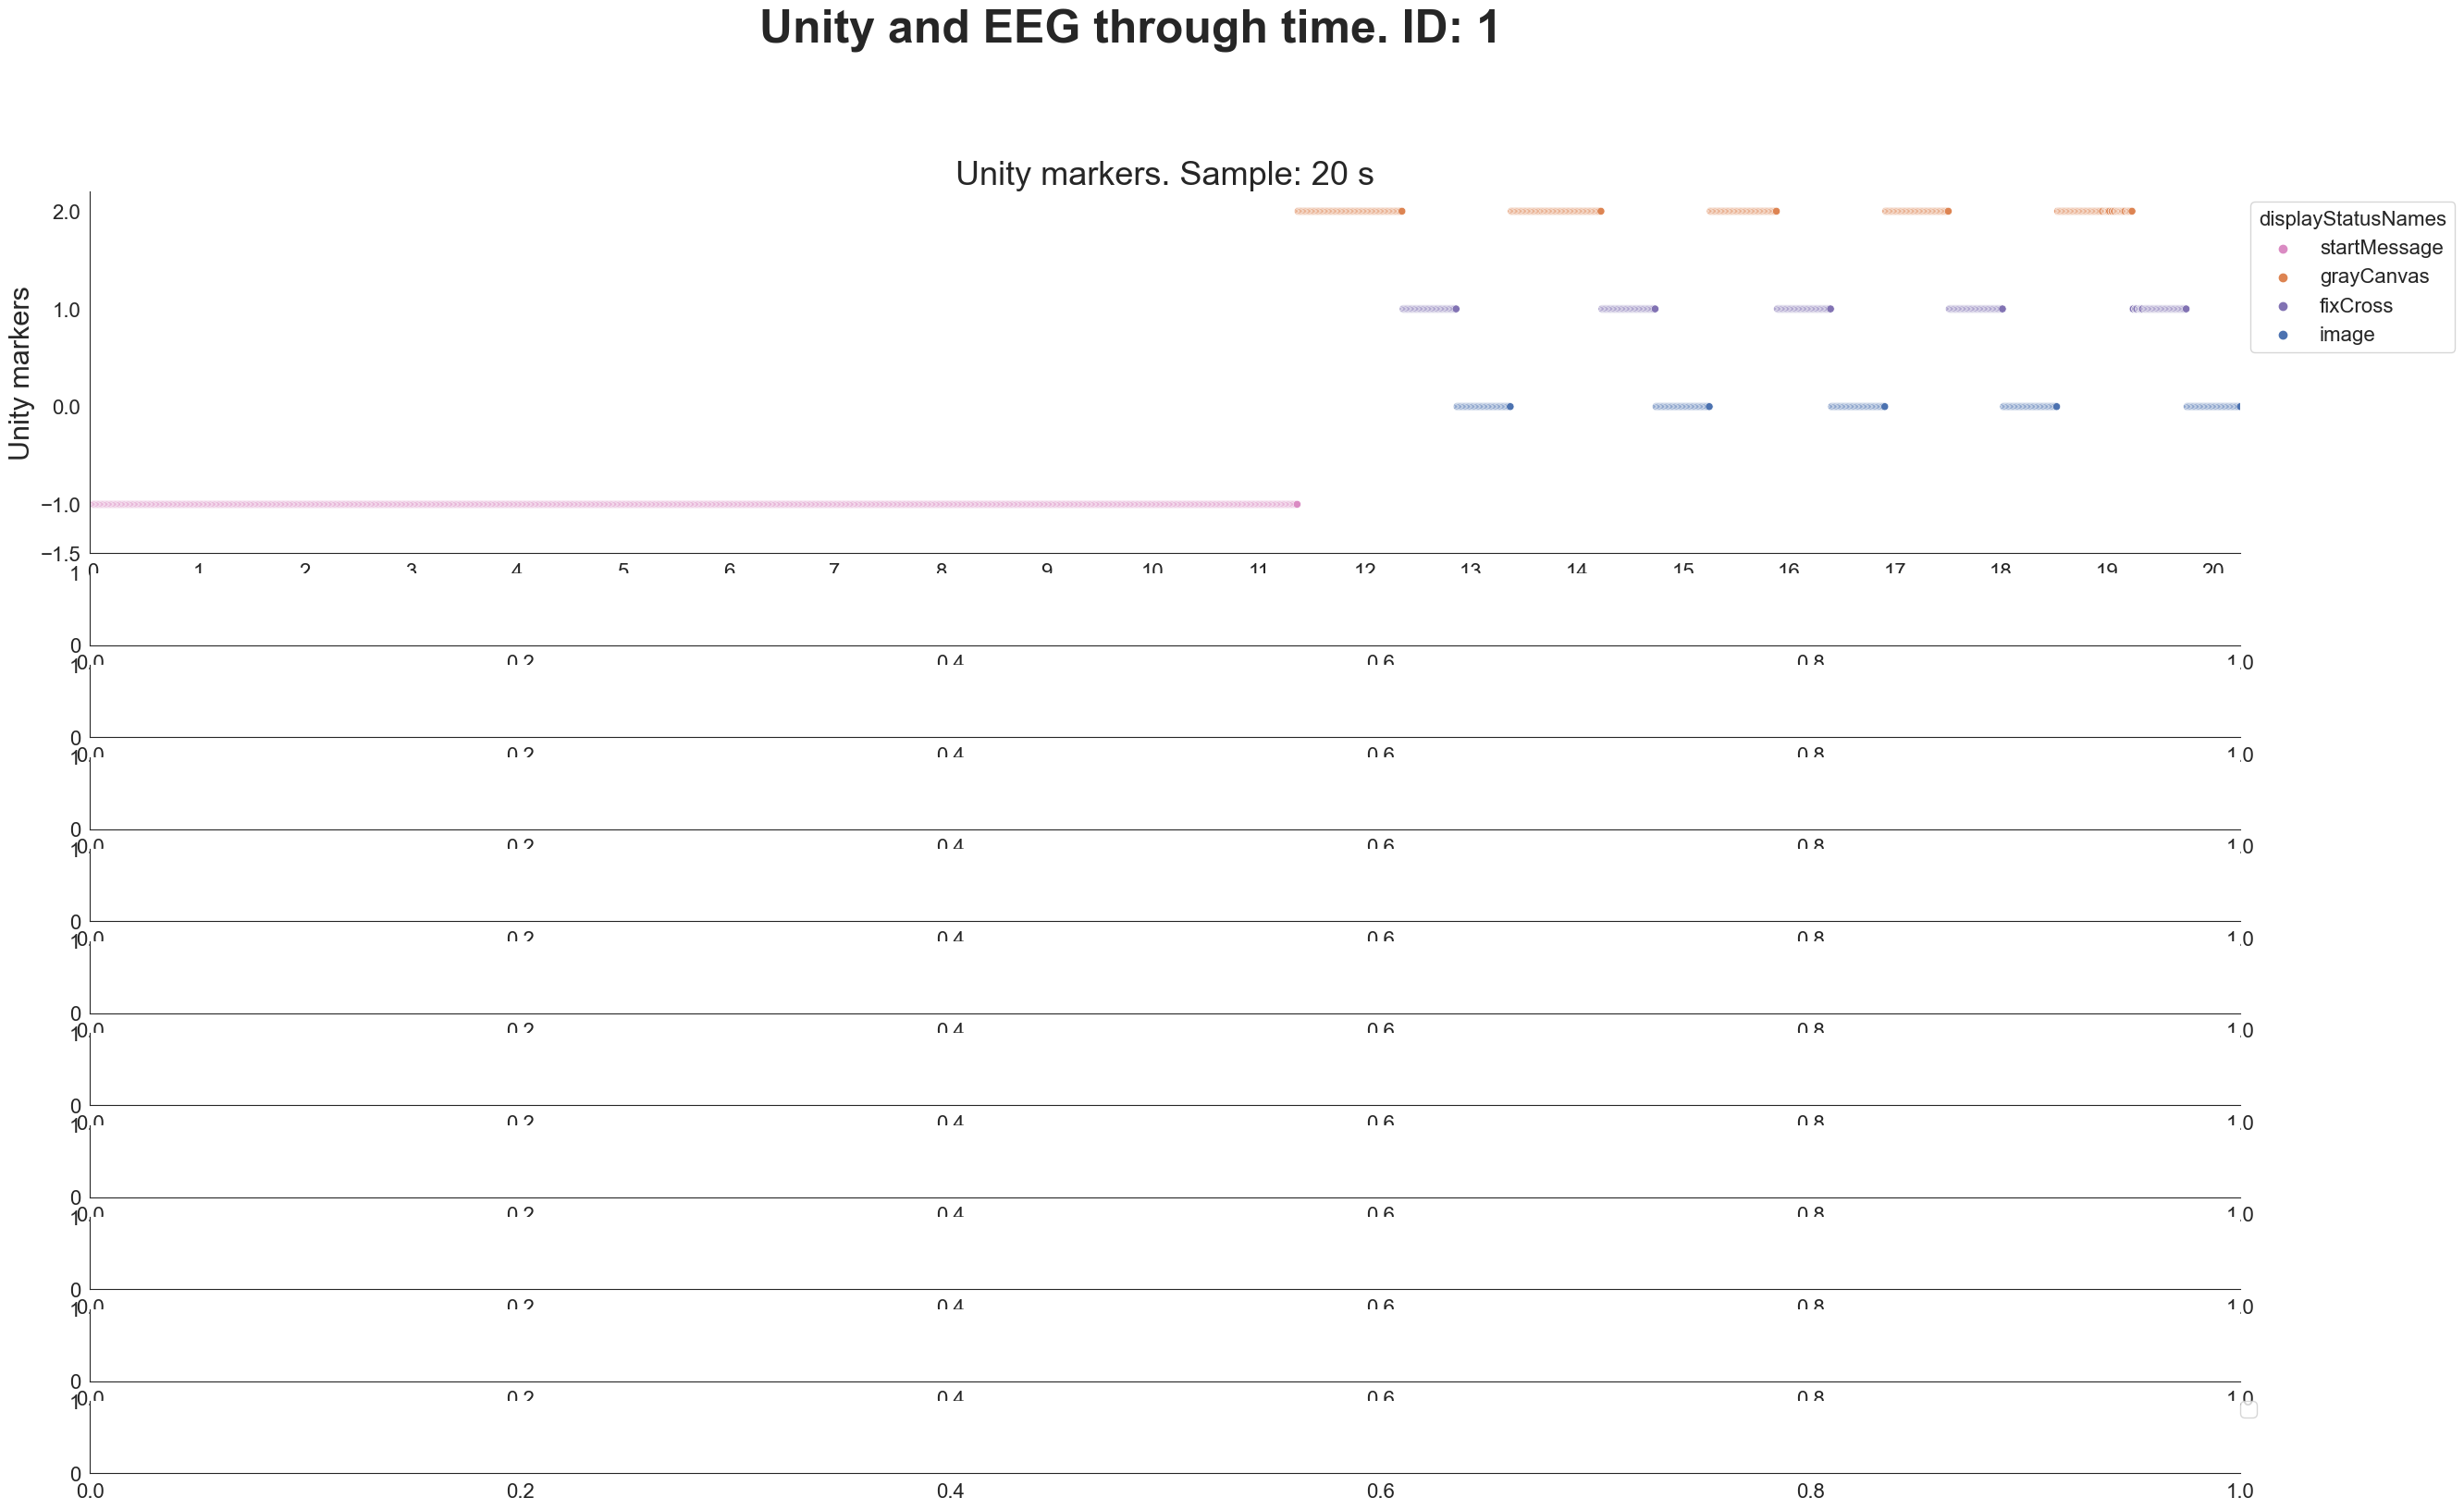

In [97]:
# df_unity_vis = df_dis_renamed[df_dis_renamed['shiftID'] < 16]
visualize_unity_eeg(df_renamed, df_eeg, id='1', save=False)

In [ ]:
# quick statistics to know if all rows have same length
df_eeg.describe()
# df['HON_HitObjectNames'].isnull().sum()
# df['HON_HitObjectNames'].unique()

In [73]:
# inspect the eye_tracking data
df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'])
df_eye

Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
Starting drift between Unity and EEG is (milliseconds) 11054.689261130989
Additional drift over time is (milliseconds) -11029.05918925535


,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,normalized_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,...,normalized_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal
0,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,74462.046032,74450.991343,0.000032,0.835990,3.712070,9.9,74462.046038,74450.991348,...,0.010143,0.000857,0.000779,-0.027600,0.079529,0.080505,0.993576,74462.046090,74450.991400,0.000090
1,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,74462.056199,74451.001551,0.010240,0.835497,3.718637,9.9,74462.056201,74451.001552,...,0.021270,0.000931,0.000782,-0.027601,0.079468,0.080826,0.993546,74462.056208,74451.001560,0.010249
2,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,74462.067304,74451.012697,0.021386,0.852361,3.723934,9.9,74462.067309,74451.012702,...,0.032359,0.000865,0.000778,-0.027600,0.081192,0.081039,0.993393,74462.067318,74451.012710,0.021400
3,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,74462.078333,74451.023767,0.032456,0.849550,3.734291,9.9,74462.078335,74451.023768,...,0.043439,0.000682,0.000767,-0.027596,0.080994,0.081665,0.993347,74462.078342,74451.023776,0.032465
4,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,74462.089357,74451.034831,0.043520,0.844325,3.731242,9.9,74462.089358,74451.034833,...,0.054614,0.000619,0.000764,-0.027596,0.080460,0.081268,0.993423,74462.089366,74451.034840,0.043529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269535,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,78908.866606,78908.840771,4457.849460,-1.190148,1.337969,9.9,78908.866607,78908.840773,...,4457.860627,-0.028767,0.000560,-0.030793,-0.084625,0.007904,0.996368,78908.866614,78908.840779,4457.849468
269536,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,78908.877782,78908.851988,4457.860677,-1.231150,1.204533,9.9,78908.877783,78908.851989,...,4457.871684,-0.028736,0.000636,-0.031071,-0.089188,-0.001938,0.996002,78908.877788,78908.851995,4457.860684
269537,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,78908.888793,78908.863040,4457.871729,-1.283957,1.140893,9.9,78908.888794,78908.863041,...,4457.882895,-0.028766,0.000605,-0.030944,-0.094666,-0.006409,0.995483,78908.888799,78908.863047,4457.871736
269538,87c8f5f3-9dc8-481b-821e-7fc676da19f5,DisplayCanvas,78908.899969,78908.874257,4457.882947,-1.251521,1.190327,9.9,78908.899971,78908.874259,...,4457.894025,-0.028753,0.000589,-0.030887,-0.091324,-0.002945,0.995804,78908.899976,78908.874264,4457.882953


In [62]:
# df_eye.describe()
df_eye.isnull().sum()

uid                                       0
HON_HitObjectNames                        0
time_stamps_HitObjectNames                0
corrected_tstamps_HitObjectNames          0
HPOOX_HitPositionOnObjects                0
HPOOY_HitPositionOnObjects                0
HPOOZ_HitPositionOnObjects                0
time_stamps_HitPositionOnObjects          0
corrected_tstamps_HitPositionOnObjects    0
HToriginX_HeadTracking                    0
HToriginY_HeadTracking                    0
HToriginZ_HeadTracking                    0
HTdirectionX_HeadTracking                 0
HTdirectionY_HeadTracking                 0
HTdirectionZ_HeadTracking                 0
time_stamps_HeadTracking                  0
corrected_tstamps_HeadTracking            0
ETWTime_EyeTrackingWorld                  0
ETWoriginX_EyeTrackingWorld               0
ETWoriginY_EyeTrackingWorld               0
ETWoriginZ_EyeTrackingWorld               0
ETWdirectionX_EyeTrackingWorld            0
ETWdirectionY_EyeTrackingWorld  

In [63]:
df_eye_start = df_eye.head(2700)
df_eye_start

,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,HToriginX_HeadTracking,...,time_stamps_EyeTrackingWorld,corrected_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal
0,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934259.969826,-0.000028,-0.058910,1.254652,9.268491,934259.969832,-0.000022,-0.049962,...,934259.969743,-0.000111,0.001660,-0.001645,-0.026984,0.021027,0.030243,0.999313,934259.969837,-0.000017
1,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934259.981034,0.011181,-0.054377,1.256271,9.268476,934259.981040,0.011187,-0.050015,...,934259.980957,0.011103,0.001720,-0.001641,-0.026984,0.021301,0.030350,0.999298,934259.981045,0.011191
2,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934259.991929,0.022075,-0.054219,1.249904,9.267124,934259.991935,0.022081,-0.050046,...,934259.991848,0.021994,0.001456,-0.001654,-0.026989,0.021164,0.029755,0.999329,934259.991940,0.022086
3,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934260.003131,0.033277,-0.058094,1.243983,9.266241,934260.003136,0.033283,-0.050074,...,934260.003066,0.033212,0.001199,-0.001667,-0.026992,0.020660,0.029205,0.999359,934260.003141,0.033287
4,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934260.015086,0.045232,-0.061399,1.243906,9.266493,934260.015092,0.045238,-0.050112,...,934260.015022,0.045168,0.001106,-0.001673,-0.026992,0.020248,0.029099,0.999359,934260.015096,0.045243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934289.911768,29.941915,0.215850,1.414243,9.354124,934289.911773,29.941919,-0.048091,...,934289.911720,29.941867,0.000658,-0.001361,-0.027143,0.049133,0.075943,0.995895,934289.911776,29.941923
2696,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934289.922863,29.953009,0.217735,1.404675,9.350187,934289.922868,29.953014,-0.048110,...,934289.922817,29.952963,0.001022,-0.001339,-0.027146,0.049133,0.075180,0.995956,934289.922872,29.953018
2697,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934289.933938,29.964085,0.214819,1.399569,9.346837,934289.933945,29.964091,-0.048137,...,934289.933870,29.964016,0.001816,-0.001295,-0.027151,0.048538,0.074753,0.996017,934289.933949,29.964095
2698,ed990ae1-f2e6-4e25-b6c1-e596181c248a,FixationCollider,934289.945064,29.975210,0.210521,1.394613,9.343207,934289.945069,29.975215,-0.048189,...,934289.945012,29.975159,0.002778,-0.001243,-0.027148,0.047852,0.074326,0.996078,934289.945072,29.975218


In [64]:
def visualize_eye(df, id='', save=True):
    # take a sample for 30 seconds of recording (30s x 90fps = 2700 datapoints)
    df_eye_start = df.head(2800)
    plt.rcParams.update({'font.size': 14})
    # rename the columns of interest
    eye_selected = df_eye_start[["corrected_tstamps_EyeTrackingWorld","HTdirectionX_HeadTracking", "HTdirectionY_HeadTracking","HTdirectionZ_HeadTracking","ETWdirectionX_EyeTrackingWorld", "ETWdirectionY_EyeTrackingWorld","ETWdirectionZ_EyeTrackingWorld"]].rename(columns={"HTdirectionX_HeadTracking": "HTdirectionX", "HTdirectionY_HeadTracking": "HTdirectionY","HTdirectionZ_HeadTracking":"HTdirectionZ","ETWdirectionX_EyeTrackingWorld": "ETdirectionX", "ETWdirectionY_EyeTrackingWorld": "ETdirectionY","ETWdirectionZ_EyeTrackingWorld":"ETdirectionZ"})
    # covert the dataframe to be tidy (long and not wide format)
    df_eye_tidy = eye_selected.melt('corrected_tstamps_EyeTrackingWorld', var_name="cols",value_name='vals')

    # create the subplots
    fig, ax = plt.subplots(nrows=3, figsize=(20, 8), sharex=True)
    fig.suptitle("Head and eye axis' directions through time. Sample "+str(round(df_eye_tidy['corrected_tstamps_EyeTrackingWorld'].max()))+" s. ID: " + id, fontsize=22, y=0.93, fontweight='bold')
    x = sns.lineplot(x="corrected_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('X')], style='cols', ax=ax[0], linewidth=3)
    ax[0].set_ylim(-1,1)
    ax[0].set_ylabel("X coordinate", fontsize=16)
    ax[0].set_xlim(0,df_eye_tidy['corrected_tstamps_EyeTrackingWorld'].max())
    x.legend_.set_title(None)

    y = sns.lineplot(x="corrected_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('Y')], style='cols', ax=ax[1], linewidth=3)
    ax[1].set_ylim(-1,1)
    ax[1].set_xlim(0,df_eye_tidy['corrected_tstamps_EyeTrackingWorld'].max())
    ax[1].set_ylabel("Y coordinate", fontsize=16)
    y.legend_.set_title(None)
    z = sns.lineplot(x="corrected_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('Z')], style='cols', ax=ax[2], linewidth=3)
    ax[2].set_ylim(-1,1)
    ax[2].set_xlim(0,df_eye_tidy['corrected_tstamps_EyeTrackingWorld'].max())
    z.legend_.set_title(None)
    ax[2].set_ylabel("Z coordinate", fontsize=16)
    ax[2].set_xlabel("Time (s)", fontsize=16)
    ax[2].locator_params(axis='x', nbins=30)
    plt.tight_layout()
    sns.despine(top=True, bottom=False)
    if save:
        plt.savefig("data/images/" + "axis_directions_" + str(round(df_eye_tidy['corrected_tstamps_EyeTrackingWorld'].max())) + '_'+ id + ".pdf", format='pdf', dpi=1200)

**Eye-tracking analysis for data recording 46:**
The starting time here corresponds to the time unity started collecting samples from the 'Visual' stream which is constantly sending samples to LabRecorder.  When visualizing the eye tracking data we can notice that the fist eye data samples collected start at around 60 seconds from the  time the LabRecorder was started. Previous to that, there is no data being collected which is how the experiment was designed. This is corroborated by the fact that the initial 'Display status name" in the infoName stream corresponds to the 'startMessage" (see image "display status" image).

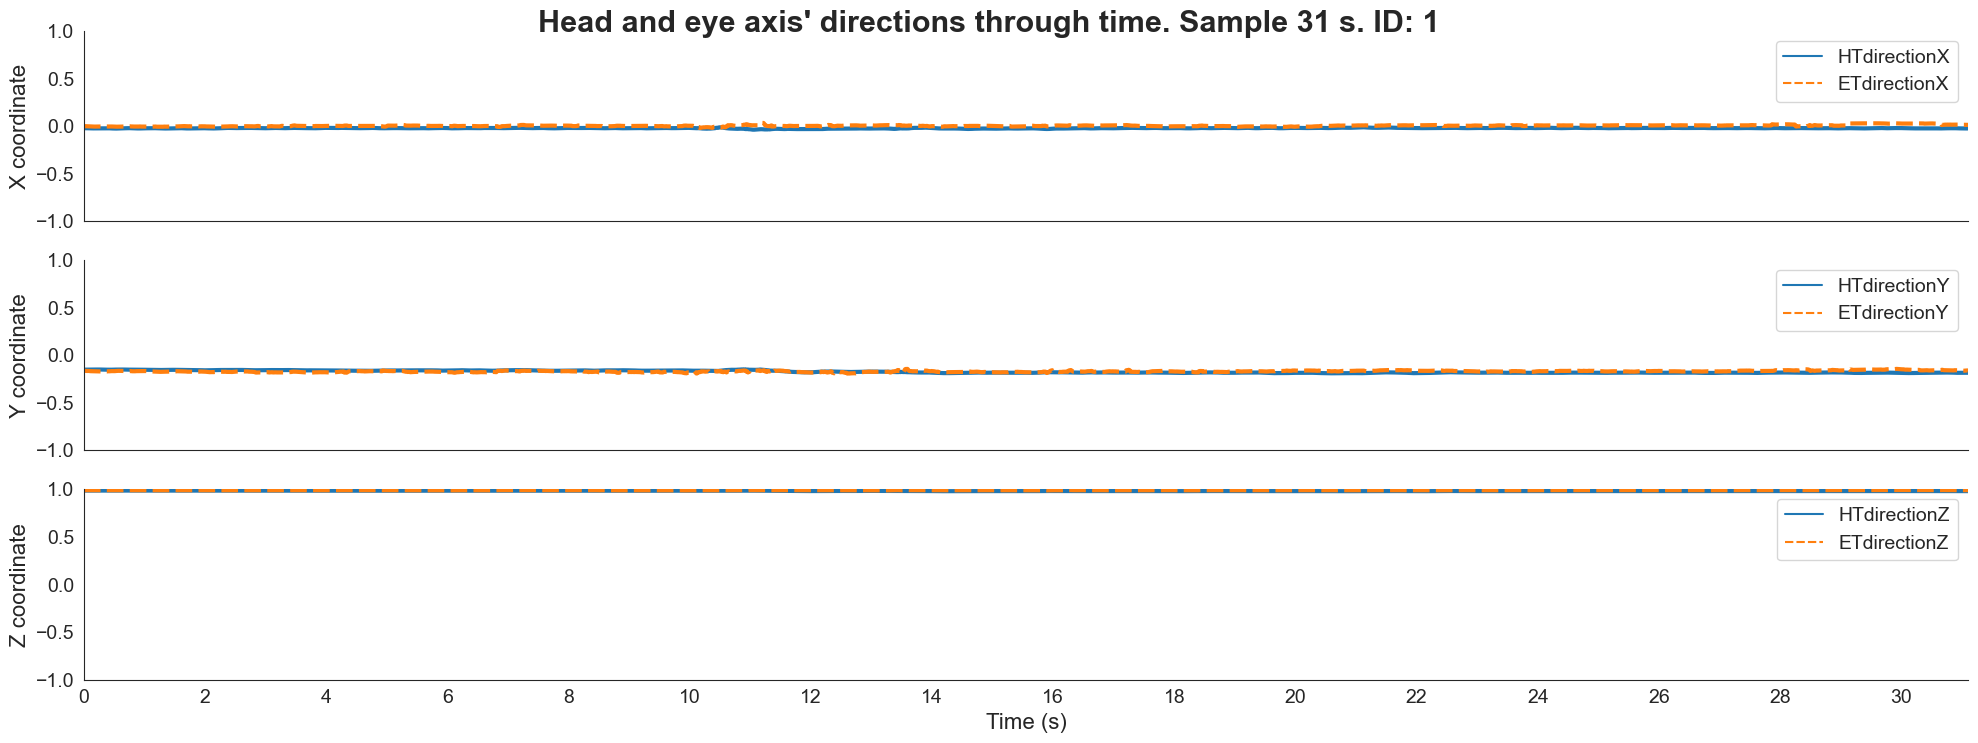

In [65]:
visualize_eye(df=df_eye, id='1', save=False)

## 3. Create triggers
- For each initial time an image was shown, we want to keep the type of object it was (i.e., face, object, body) as a separate column.
- Additional triggers contain the rotation and distance the specific object was with respect to the player at the time the free-viewing walk took place.
- __Note:__ We want the triggers only once to denote the initial time the image was shown.

In [98]:
def create_triggers(df):
    # save the names of the object, body or face shown in the image
    df['ob_names'] =  df.apply(lambda x: x["imageName_ImageInfo"].split(".")[5] if len(x["imageName_ImageInfo"].split(".")) > 7 else '', axis=1)
    # create the triggers to mark the start of image displaying
    # check when there is a change from image, canvas, fixationCross
    df['shift'] = df['imageName_ImageInfo'].shift(1) != df['imageName_ImageInfo']
    # save the starting time (aka 'latency') when image is displayed
    df['latency'] = df.apply(lambda x: x['normalized_tstamps_ImageInfo'] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # save the type of image displaying (face, object, body)
    df['type'] = df.apply(lambda x: 'face' if x['shift'] and 'face' in x['imageName_ImageInfo'].lower()
                                            else ('body' if x['shift'] and 'npc' in x['imageName_ImageInfo'].lower()
                                            else ('object' if x['shift'] and 'rotation' in x['imageName_ImageInfo'].lower()
                                            and 'face|npc' not in x['imageName_ImageInfo'].lower()
                                            else '')), axis=1)
    # define the triggers for rotation, distance, and block
    df['rotation'] = df.apply(lambda x: 'r_' + x["imageName_ImageInfo"].split(".")[7] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['distance'] = df.apply(lambda x: 'd_' + x["imageName_ImageInfo"].split(".")[9] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['block'] = df.apply(lambda x: 'b_' + str(x["blockNumber_ImageInfo"]) if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # select the trigger columns and non empty rows
    df_sel = df[['latency','type','rotation','distance','block']]
    df_triggers = df_sel[df_sel['latency'] != '']
    # save first uid for later usage
    uid = df['uid'][0]
    return df, df_triggers, uid

In [99]:
df, df_triggers, uid = create_triggers(df_img_info)
df

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,...,normalized_tstamps_Visual,displayStatusNames,shift,shiftID,ob_names,latency,type,rotation,distance,block
0,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.194442,74451.002419,0.011108,4329.0,-1.0,85.366096,74451.194436,...,0.011102,startMessage,True,0,,,,,,
1,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.205621,74451.013597,0.022287,4330.0,-1.0,85.377274,74451.205614,...,0.022280,startMessage,False,0,,,,,,
2,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.216554,74451.024531,0.033220,4331.0,-1.0,85.388214,74451.216550,...,0.033216,startMessage,False,0,,,,,,
3,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.227691,74451.035667,0.044356,4332.0,-1.0,85.399345,74451.227685,...,0.044351,startMessage,False,0,,,,,,
4,87c8f5f3-9dc8-481b-821e-7fc676da19f5,0,startMessage,74451.238694,74451.046670,0.055359,4333.0,-1.0,85.410355,74451.238690,...,0.055356,startMessage,False,0,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381083,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.144506,78908.863515,4457.872205,385406.0,99.0,4543.284180,78909.144500,...,4457.872199,,False,5044,,,,,,
381084,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.155422,78908.874431,4457.883121,385407.0,99.0,4543.295410,78909.155416,...,4457.883115,,False,5044,,,,,,
381085,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.166441,78908.885451,4457.894140,385408.0,99.0,4543.306152,78909.166438,...,4457.894136,,False,5044,,,,,,
381086,87c8f5f3-9dc8-481b-821e-7fc676da19f5,3,endMessage,78909.177579,78908.896588,4457.905278,385409.0,99.0,4543.317383,78909.177574,...,4457.905273,,False,5044,,,,,,


In [100]:
df_triggers

,latency,type,rotation,distance,block
1158,12.871929,object,r_3,d_17,b_0
1327,14.748881,face,r_93,d_1,b_0
1476,16.40343,body,r_54,d_5,b_0
1622,18.024954,face,r_111,d_2,b_0
1777,19.757412,object,r_73,d_72,b_0
...,...,...,...,...,...
380391,4450.186912,object,r_32,d_50,b_3
380545,4451.897437,object,r_152,d_6,b_3
380690,4453.507559,object,r_54,d_72,b_3
380866,4455.46231,object,r_8,d_36,b_3


In [101]:
# sort data files alphabetically
files_s = os.listdir(r_path)
files_s.sort()
# path to save .csv with total images per block
total_img_file = os.path.join(t_path, 'total_unique_images_per_user.csv')
desc_file_streams = os.path.join(t_path, 'desc_files_streams.csv')

# progress bar format definitons
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = ("{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s")
# main progress bar
main_bar = tqdm(
    files_s,
    #os.listdir(r_path),
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
# for k in main_bar:
for file in main_bar:
    if file.lower().endswith('.xdf'):
        # Skip if not a first part of a recording
        if 'room2' in file:
            continue
        pbar = tqdm(
        range(7),
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,)

        pbar.set_postfix(file=file)
        #### 1. Load the XDF file ####
        postfix = {"step": "1. Load the XDF file", "file": file}
        # set flag if a second recording for same subject
        file2 = file.replace('room1', 'room2')
        second_rec = True if os.path.isfile(os.path.join(r_path, file2)) else False

        pbar.set_postfix(postfix)
        streams, _ = pyxdf.load_xdf(os.path.join(r_path, file))
        # read streams from second file if it exists
        if second_rec:
            streams2, _ = pyxdf.load_xdf(os.path.join(r_path, file2))

        pbar.update(1)
        #### 2. Store selected stream info (only useful info)
        postfix = {"step": "2. Store selected streams info", "file": file}
        pbar.set_postfix(postfix)
        # store trigger-related stream data into df and use the Visual stream for first timestamp reference
        # we could also use 'openvibeSignal' stream as time reference, but we do not use that stream due to drift in data
        df = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal')
        if second_rec:
            # store the df for second recording if subject has to recordings
            df2 = get_streams_data(streams2, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal')
            # combine both df into one
            df = pd.concat([df,df2], ignore_index=True)

        # drop nan values
        df = df.dropna().reset_index(drop=True)

        # save eye_tracking related data
        df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'], time_ref_stream='Visual')
        if second_rec:
            # save eye df for second recording if subject has to recordings
            df_eye2 = get_streams_data(streams2, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'], time_ref_stream='openvibeSignal')
            # combine both df into one
            df_eye = pd.concat([df_eye,df_eye2], ignore_index=True)
        pbar.update(1)

        #### 3. Create triggers ####
        postfix = {"step": "3. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        df_img, df_triggers, uid = create_triggers(df)
        pbar.update(1)

        #### 4. Create and save visualizations ####
        postfix = {"step": "4.  Creating and saving visualizations", "file": file}
        pbar.set_postfix(postfix)
        # get the eeg data from streams
        df_eeg = stract_eeg_data(streams)
        # # take the first 30 seconds of recording (30s x 90fps) and rename names in 'displayStatusNames' column
        # df_starts = df.head(2700)
        df_renamed = rename_displays(df)
        # visualize the first 30 seconds of recording
        # visualize_unity_eeg(df_renamed, df_eeg, id=uid)
        plt.close()
        # visualize_eye(df=df_eye, id=uid)
        plt.close()
        pbar.update(1)

        #### 5. Save total number of images per block, per uid  ####
        postfix = {"step": "5 Saving total number of images per block, per uid", "file": file}
        pbar.set_postfix(postfix)
        img_unique = df_img[~df_img['imageName_ImageInfo'].str.contains('fixation|grayCan|Message')]
        total_images = img_unique.groupby('blockNumber_ImageInfo')['imageName_ImageInfo'].nunique().reset_index().rename(columns={"blockNumber_ImageInfo": "block_number", "imageName_ImageInfo": "total_img"})
        # convert column to numeric to drop the duplicates correctly
        total_images['block_number'] = pd.to_numeric(total_images['block_number'])

        # save total images for all participants
        if not os.path.isdir(t_path):
            os.mkdir(t_path)
        if not os.path.isdir(e_path):
            os.mkdir(e_path)
        desc_streams = describe_recordings(streams, file_name=file)

        #### 6. Create streams description per recording  ####
        postfix = {"step": "6. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        if os.path.exists(desc_file_streams):
            df_desc_files = pd.read_csv(desc_file_streams)
            df_desc_files = pd.concat([df_desc_files,desc_streams], ignore_index=True)
            df_desc_files.reset_index(drop=True, inplace=True)
            df_desc_files.drop_duplicates(inplace=True, ignore_index=True)
        else:
            df_desc_files = desc_streams
        df_desc_files.to_csv(desc_file_streams, index=False)
        pbar.update(1)

        total_images['uid'] = uid # add colum to total images csv with uid
        if os.path.exists(total_img_file):
            df_total_unique_img = pd.read_csv(total_img_file)
            df_total_unique_img = pd.concat([df_total_unique_img,total_images], ignore_index=True)
            df_total_unique_img.reset_index(drop=True, inplace=True)
            df_total_unique_img.drop_duplicates(inplace=True, ignore_index=True)

        else:
            df_total_unique_img = total_images
        df_total_unique_img.to_csv(total_img_file, index=False)
        pbar.update(1)
        #### 7. Saving triggers and et files ####
        postfix = {"step": "7. Saving triggers and et files", "file": file}
        pbar.set_postfix(postfix)
        df_triggers.to_csv(os.path.join(t_path, 'trigger_file_' + uid +'.csv'), index=False)
        # df_eye.to_csv(os.path.join(e_path, 'et_' + uid + '.csv'), index=False)
        pbar.update(1)
        pbar.set_postfix(file=file)
        pbar.close()

Processed:            0% 0/8 in 0.13s

:            0% 0/7 in 0.03s

Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
Starting drift between Unity and EEG is 192.023125680862 (milliseconds)
Additional drift over time is 88.96815791376866 (milliseconds)
Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
Starting drift between Unity and EEG is 10850.69699503947 (milliseconds)
Additional drift over time is -11128.281265380792 (milliseconds)
